In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd gdrive/MyDrive/hdr

Mounted at /content/gdrive
/content/gdrive/MyDrive/hdr


In [2]:
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

In [4]:
X = train.drop(['label'], axis=1).values
y = train['label'].values

In [5]:
# Normalization to 0 - 1
X_norm = X / 255.0
X_reshaped = X_norm.reshape(-1, 28, 28, 1)

In [6]:
# Split the train and validation set in 8 : 2
X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)
print(f"X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

X_train: (33600, 28, 28, 1), X_val: (8400, 28, 28, 1), y_train: (33600,), y_val: (8400,)


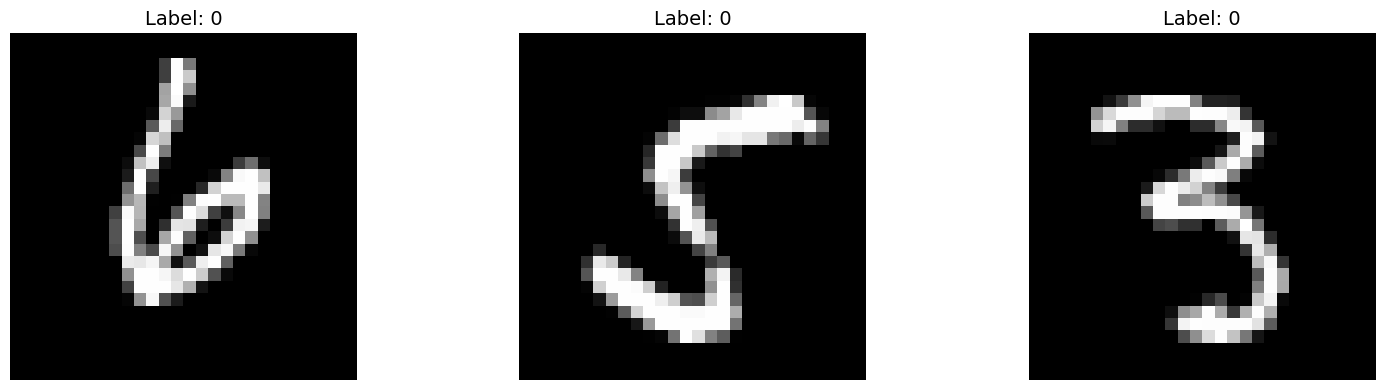

In [7]:
# Plot first three picture
X_showcase = X_train.reshape(X_train.shape[0], 28, 28)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for i, ax in enumerate(axes):
    ax.imshow(X_showcase[i], cmap='gray')
    digit = y_train[i].argmax()
    ax.set_title(f"Label: {digit}", fontsize=14)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [18]:
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        # Input size: (1, 28, 28)
        # First conv layer: (64, 26, 26) [28 - 3 + 1 = 26]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=0)
        # Second conv layer: (64, 24, 24) [26 - 3 + 1 = 24]
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=0)
        # Pooling: (24, 24) -> (12, 12)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(64)

        # Input size: (64, 12, 12)
        # Third conv layer: (128, 10, 10) [12 - 3 + 1 = 10]
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
        # Fourth conv layer: (128, 8, 8) [10 - 3 + 1 = 8]
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=0)
        # Pooling: (8, 8) -> (4, 4)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(128)

        # Input size: (128, 4, 4)
        # Fifth conv layer: (256, 2, 2) [4 - 3 + 1 = 2]
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=0)
        # Pooling: (2, 2) -> (1, 1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256 * 1 * 1, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.bn1(x)

        # Second conv block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.bn2(x)

        # Third conv block
        x = F.relu(self.conv5(x))
        x = self.pool3(x)
        x = self.bn3(x)

        # (N, 256, 1, 1) -> (N, 256)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [30]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
        scale=(0.99, 1.01)
    ),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

In [24]:
class HdrDataset(Dataset):
    def __init__(self, X, y, transform=train_transform):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        image = self.transform(image)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return image, label_tensor

In [25]:
train_dataset = HdrDataset(X_train, y_train, transform=train_transform)
val_dataset = HdrDataset(X_val, y_val, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [26]:
import copy
import torch

class EarlyStopping:
    def __init__(self, patience=10, mode='max', restore_best_weights=True):
        self.patience = patience
        self.mode = mode
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.best_weights = None
        self.wait = 0
        self.stopped_epoch = 0
        self.early_stop = False

    def __call__(self, current_score, model, epoch):
        if self.best_score is None:
            self.best_score = current_score
            self.best_weights = copy.deepcopy(model.state_dict())
        else:
            if (self.mode == 'max' and current_score > self.best_score) or \
               (self.mode == 'min' and current_score < self.best_score):
                self.best_score = current_score
                self.best_weights = copy.deepcopy(model.state_dict())
                self.wait = 0
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.early_stop = True

    def load_best_weights(self, model):
        if self.restore_best_weights and self.best_weights is not None:
            model.load_state_dict(self.best_weights)

In [27]:
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel1().to(device)
criterion = nn.MultiMarginLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.2,
    patience=3,
    min_lr=1e-5
)

In [29]:
early_stopping = EarlyStopping(patience=10, mode='max', restore_best_weights=True)

epochs = 100
for epoch in range(1, epochs+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Epoch [{epoch}/{epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    early_stopping(val_acc, model, epoch)
    if early_stopping.early_stop:
        print(f"Early stopping at epoch {epoch}")
        break

early_stopping.load_best_weights(model)
print("Training complete!")

Epoch [1/100] | Train Loss: 0.0884, Train Acc: 83.15% | Val Loss: 0.0165, Val Acc: 95.74%
Epoch [2/100] | Train Loss: 0.0279, Train Acc: 93.07% | Val Loss: 0.0131, Val Acc: 96.65%
Epoch [3/100] | Train Loss: 0.0206, Train Acc: 94.77% | Val Loss: 0.0065, Val Acc: 98.29%
Epoch [4/100] | Train Loss: 0.0179, Train Acc: 95.41% | Val Loss: 0.0068, Val Acc: 97.94%
Epoch [5/100] | Train Loss: 0.0164, Train Acc: 95.86% | Val Loss: 0.0064, Val Acc: 98.12%
Epoch [6/100] | Train Loss: 0.0150, Train Acc: 96.10% | Val Loss: 0.0070, Val Acc: 97.77%
Epoch [7/100] | Train Loss: 0.0144, Train Acc: 96.22% | Val Loss: 0.0080, Val Acc: 97.63%
Epoch [8/100] | Train Loss: 0.0097, Train Acc: 97.37% | Val Loss: 0.0043, Val Acc: 98.80%
Epoch [9/100] | Train Loss: 0.0077, Train Acc: 97.76% | Val Loss: 0.0037, Val Acc: 99.01%
Epoch [10/100] | Train Loss: 0.0073, Train Acc: 97.92% | Val Loss: 0.0032, Val Acc: 99.04%
Epoch [11/100] | Train Loss: 0.0073, Train Acc: 97.90% | Val Loss: 0.0031, Val Acc: 99.14%
Epoch [1

In [22]:
validate_one_epoch(model, val_loader, criterion, device)

Test Loss: 0.0107
Test Accuracy: 99.67%


In [21]:
early_stopping.best_score

99.60714285714286